In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import skimage
from scipy.fftpack import dct, idct

In [3]:
img_rgb = Image.open("./cat.tiff")
img_gray = img_rgb.convert('L')
img_arr_rgb = np.array(img_rgb)
img_arr_gray = np.array(img_gray)

In [4]:
print(img_arr_rgb.shape)
print(img_arr_gray.shape)

(331, 500, 4)
(331, 500)


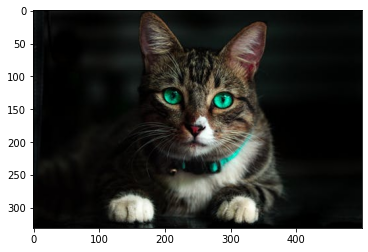

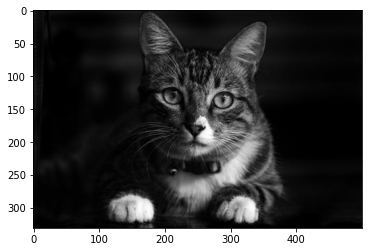

In [5]:
plt.imshow(img_arr_rgb)
plt.show()
plt.imshow(img_arr_gray, cmap='gray')
plt.show()

### From RGB to YUV

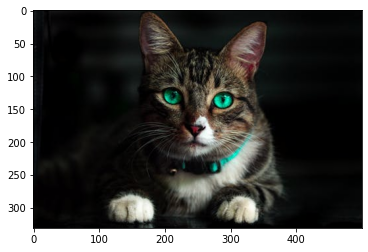

In [6]:
# from RGB to YUV

def to_yuv(img):
    '''
    RGB image into YUV
    '''
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]

    y = 0.299 * r  + 0.587 * g + 0.114 * b
    u = -0.14713 * r  +  -0.28886 * g + 0.436 * b
    v = 0.615 * r  +  -0.51499 * g + -0.10001 * b

    return y, u, v

def to_rgb(img):
    '''
    From YUV to RGB
    '''
    y = img[:, :, 0]
    u = img[:, :, 1]
    v = img[:, :, 2]

    r = (y + 1.13983 * v).astype('uint8')
    g = (y + -0.39465 * u + -0.58060 * v).astype('uint8')
    b = (y + 2.03211 * u).astype('uint8')

    return r, g, b

y, u, v = to_yuv(img_arr_rgb)
img_yuv = np.dstack((y, u, v))
r, g, b = to_rgb(img_yuv)
img_rgb = np.dstack((r, g, b))
plt.imshow(img_rgb)
plt.show()

### Transform the image into 8x8 blocks

In [7]:
def get_next_8(nbr):
    '''
    Get next multiple of 8
    '''
    if nbr % 8 == 0:
        return nbr
    r = nbr // 8
    return (r + 1) * 8

def zeros_padding(img):
    '''
    Padd the image with 0
    '''
    shape = img.shape

    # nbr of columns/rows to add
    diff_rows = get_next_8(shape[0]) - shape[0]
    diff_cols = get_next_8(shape[1]) - shape[1]

    if diff_cols != 0:
        zeros_cols = np.zeros((shape[0], diff_cols))
        img = np.concatenate((img, zeros_cols), axis=1)

    if diff_rows != 0:
        zeros_rows = np.zeros((diff_rows, shape[1] + diff_cols))
        img = np.concatenate((img, zeros_rows), axis=0)

    return img

def symmetrical_padding(img):
    '''
    Padd the image with symmetrical rows and columns
    -> avoid creating high frequencies
    '''
    shape = img.shape

    # nbr of column/rows to add
    diff_rows = get_next_8(shape[0]) - shape[0]
    diff_cols = get_next_8(shape[1]) - shape[1]


    if diff_cols != 0:
        sym_arr = np.flip(img[:, -diff_cols:], axis=1)
        img = np.concatenate((img, sym_arr), axis=1)

    if diff_rows != 0:
        sym_arr = np.flip(img[-diff_rows:, :], axis=0)
        img = np.concatenate((img, sym_arr), axis=0)

    return img

def get_blocks(img, padding='zeros'):
    '''
    Get all the blocks (8x8)
    padding: 'zeros'/'symmetrical'
    '''
    if padding == 'zeros':
        img = zeros_padding(img)
    elif padding == 'symmetrical':
        img = symmetrical_padding(img)
    else:
        print("ERROR unknown padding")

    shape = img.shape

    n_rows = shape[0] // 8
    n_cols = shape[1] // 8
    res = np.empty((n_rows, n_cols, 8, 8))

    for i in range(n_rows):
        for j in range(n_cols):
            row_min, row_max = i * 8, (i + 1) * 8
            col_min, col_max = j * 8, (j + 1) * 8
            res[i, j, :, :] = img[row_min:row_max, col_min:col_max]

    return res

def from_blocks_to_image(blocks):
    '''
    Convert matrix from blocks representation into image representation
    '''
    shape = blocks.shape
    res = np.empty((shape[0] * 8, shape[1] * 8))
    for i in range(shape[0]):
        for j in range(shape[1]):
            row_min, row_max = i * 8, (i + 1) * 8
            col_min, col_max = j * 8, (j + 1) * 8
            res[row_min:row_max, col_min:col_max] = blocks[i, j]
        
    return res

blocks = get_blocks(img_arr_gray, padding='symmetrical')
tmp = from_blocks_to_image(blocks)

img = symmetrical_padding(img_arr_gray)
np.all(tmp==img)

True

### DCT

Formulas taken from this paper: http://m.reznik.org/papers/SPIE07_MPEG-C_IDCT.pdf

In [46]:
## COMPRESSION

def apply_dct(block):
    return np.round(dct(dct((block-128).T, norm='ortho').T, norm='ortho'))

def compute_dct(img_blocks):
    shape = img_blocks.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            img_blocks[i, j, :, :] = apply_dct(img_blocks[i, j])
    return img_blocks
    
def apply_idct(block):
    return np.round(idct(idct(block.T, norm='ortho').T, norm='ortho')) + 128

def compute_idct(img_blocks):
    shape = img_blocks.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            img_blocks[i, j, :, :] = apply_idct(img_blocks[i, j])
    return img_blocks
    

#mat = np.array([
#        [52, 55, 61, 66, 70, 61, 64, 73],
#        [63, 59, 55, 90, 109, 85, 69, 72],
#        [62, 59, 68, 113, 144, 104, 66, 73],
#        [63, 58, 71, 122, 154, 106, 70, 69],
#        [67, 61, 68, 104, 126, 88, 68, 70],
#        [79, 65, 60, 70, 77, 68, 58, 75],
#        [85, 71, 64, 59, 55, 61, 65, 83],
#        [87, 79, 69, 68, 65, 76, 78, 94]
#    ], dtype=float)

mat = np.array([
  [16,  11,  10,  16,  24,  40,  51,  61],
  [12,  12,  14,  19,  26,  58,  60,  55],
  [14,  13,  16,  24,  40,  57,  69,  56],
  [14,  17,  22,  29,  51,  87,  80,  62],
  [18,  22,  37,  56,  68, 109, 103,  77],
  [24,  35,  55,  64,  81, 104, 113,  92],
  [49,  64,  78,  87, 103, 121, 120, 101],
  [72,  92,  95,  98, 112, 100, 103,  99]], dtype=float)

blocks_img = mat.reshape((1, 1, 8, 8))
print(blocks_img)
res = compute_dct(blocks_img)
print(res)
print(compute_idct(res))

[[[[ 16.  11.  10.  16.  24.  40.  51.  61.]
   [ 12.  12.  14.  19.  26.  58.  60.  55.]
   [ 14.  13.  16.  24.  40.  57.  69.  56.]
   [ 14.  17.  22.  29.  51.  87.  80.  62.]
   [ 18.  22.  37.  56.  68. 109. 103.  77.]
   [ 24.  35.  55.  64.  81. 104. 113.  92.]
   [ 49.  64.  78.  87. 103. 121. 120. 101.]
   [ 72.  92.  95.  98. 112. 100. 103.  99.]]]]
[[[[-563. -168.  -15.   30.  -31.    9.    1.   -3.]
   [-194.   -2.   38.    5.    7.    4.    6.   -6.]
   [  32.   44.   11.  -22.   15.  -11.   -6.    4.]
   [  -3.  -28.   -1.   -0.   -3.    7.    4.   -3.]
   [   2.   11.    1.    1.    4.   -5.    1.   -3.]
   [  -1.   -4.    2.    3.    1.   -3.    0.    3.]
   [ -10.    6.    4.   -9.    8.   -1.   -6.    8.]
   [   8.   -2.   -3.    1.    3.    4.   -2.   -1.]]]]
[[[[ 16.  11.   9.  16.  24.  40.  51.  61.]
   [ 13.  12.  14.  19.  26.  58.  60.  55.]
   [ 14.  12.  16.  24.  40.  57.  69.  56.]
   [ 14.  17.  22.  29.  51.  87.  80.  62.]
   [ 18.  22.  37.  56.  68. 1

### Quantification step

In [9]:
## COMPRESSION

def quantification(block, luminance=True, q=75):
    '''
    Quantification step on 1 8x8 block
    luminance: Wether it's for luminance or chrominance image
    '''

    if luminance:
        q_luminance = np.array([
            [16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]
        ])
        
        if q < 50:
            alpha = 5000 / q
        else:
            alpha = 200  - 2 * q
        q_luminance = (alpha * q_luminance + 50) / 100
        return np.round(block / q_luminance), q_luminance

    else:
        q_chrominance = np.array([
            [17, 18, 24, 47, 99, 99, 99, 99],
            [18, 21, 26, 66, 99, 99, 99, 99],
            [24, 26, 56, 99, 99, 99, 99, 99],
            [47, 66, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99]
        ])
        
        return np.round(block / q_chrominance), q_chrominance
    
def compute_quantification(img_blocks, luminance=True, q=75):
    '''
    Compute quantification on each block
    luminance: weather its a luminance block or not
    q: compression quality
    '''
    shape = img_blocks.shape
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            img_blocks[i, j, :, :], q_mat = quantification(img_blocks[i, j], luminance, q)
    return img_blocks, q_mat

## DECOMPRESSION

def dequantification(block, quantification_mat):
    '''
    Quantification step on 1 8x8 block
    luminance: Wether it's for luminance or chrominance image
    '''
    return np.einsum('ij,ij->ij', block, quantification_mat)

def compute_dequantification(img_blocks, quantification_mat):
    '''
    Dequantification step on each block
    '''
    shape = img_blocks.shape
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            img_blocks[i, j, :, :] = dequantification(img_blocks[i, j], quantification_mat)
    return img_blocks

mat = np.array([
  [16,  11,  10,  16,  24,  40,  51,  61],
  [12,  12,  14,  19,  26,  58,  60,  55],
  [14,  13,  16,  24,  40,  57,  69,  56],
  [14,  17,  22,  29,  51,  87,  80,  62],
  [18,  22,  37,  56,  68, 109, 103,  77],
  [24,  35,  55,  64,  81, 104, 113,  92],
  [49,  64,  78,  87, 103, 121, 120, 101],
  [72,  92,  95,  98, 112, 100, 103,  99]], dtype=float)

# quantification 
mat_blocks = mat.reshape((1, 1, 8, 8))
mat_DCT = compute_DCT(mat_blocks)
print("MAT after DCT ")
print(mat_DCT)
print()
mat_quant, q_mat = compute_quantification(mat_DCT, luminance=True, q=90)
print("MAT after quantification")
print(mat_quant)
print()
print("Quantificaton matrix")
print(q_mat)
print()

# dequantification
mat_dequant = compute_dequantification(mat_quant, q_mat)
print("MAT after dequantification")
print(mat_dequant)

MAT after DCT 
[[[[-563. -168.  -15.   30.  -31.    9.    1.   -3.]
   [-194.   -2.   38.    5.    7.    4.    6.   -6.]
   [  32.   44.   11.  -22.   15.  -11.   -6.    4.]
   [  -3.  -28.   -1.   -0.   -3.    7.    4.   -3.]
   [   2.   11.    1.    1.    4.   -5.    1.   -3.]
   [  -1.   -4.    2.    3.    1.   -3.    0.    3.]
   [ -10.    6.    4.   -9.    8.   -1.   -6.    8.]
   [   8.   -2.   -3.    1.    3.    4.   -2.   -1.]]]]

MAT after quantification
[[[[-152.  -62.   -6.    8.   -6.    1.    0.   -0.]
   [ -67.   -1.   12.    1.    1.    0.    0.   -1.]
   [  10.   14.    3.   -4.    2.   -1.   -0.    0.]
   [  -1.   -7.   -0.   -0.   -0.    0.    0.   -0.]
   [   0.    2.    0.    0.    0.   -0.    0.   -0.]
   [  -0.   -1.    0.    0.    0.   -0.    0.    0.]
   [  -1.    0.    0.   -1.    0.   -0.   -0.    0.]
   [   1.   -0.   -0.    0.    0.    0.   -0.   -0.]]]]

Quantificaton matrix
[[ 3.7  2.7  2.5  3.7  5.3  8.5 10.7 12.7]
 [ 2.9  2.9  3.3  4.3  5.7 12.1 12.5 11.

In [45]:
def reverse_zigzag(mat):
    '''
    Reverse Zigzag iteration over matrix 'mat' to count nb of zeros
    '''
    shape = mat.shape
    n_rows, n_cols = shape[0], shape[1]
    i, j, idx = n_rows - 1, n_cols - 1, 0

    # first element case
    if (mat[i, j] != 0):
        return idx
    idx += 1

    while (idx < n_rows * n_cols):
        # after diagonals cases
        if (j > 0):
            j -= 1
        else:
            i -= 1

        # diagonal from left to right
        while (j < n_cols and i >= 0):
            if (mat[i, j] != 0):
                return idx
            idx += 1
            i -= 1
            j += 1

        # rectify out of bound
        j -= 1
        i += 1

        # corner case
        if (i > 0):
            i -= 1
        else:
            j -= 1

        # diagonal from right to left
        while (j >= 0 and i < n_rows):
            if (mat[i, j] != 0):
                return idx
            idx += 1
            j -= 1
            i += 1

        # out of bound
        j += 1
        i -= 1
    
    return idx

## COMPRESSION


def zigzag(mat):
    '''
    Zigzag iteration over matrix 'mat'
    '''
    # init
    i, j, idx = 0, 0, 0
    n_rows, n_cols = mat.shape

    nb_elm = reverse_zigzag(mat)
    nb_elm = n_rows * n_cols - nb_elm

    if (nb_elm == 0):
        return np.array([])
    res = np.zeros(nb_elm)

    # first element case
    res[idx] = mat[i][j]
    idx += 1

    while (idx < nb_elm):
        if (j < n_cols -1):
            j += 1
        else:
            i += 1

        # diagonal from right to left
        while (j >= 0 and i < n_rows):
            if (idx >= nb_elm):
                return res
            res[idx] = mat[i][j]
            idx += 1
            i += 1
            j -= 1

        # out of bound i and j
        j += 1
        i -= 1

        if (i < n_rows - 1):
            i += 1
        else:
            j += 1

        # diagonal from left to right
        while (i >= 0 and j < n_cols):
            if (idx >= nb_elm):
                return res
            res[idx] = mat[i][j]
            idx += 1
            i -= 1
            j += 1

        # out of bound i and j
        i += 1
        j -= 1

    return res

def apply_zigzag(mat_blocks):
    '''
    Apply zigzag on each block
    '''
    shape = mat_blocks.shape
    res = []
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            res.append(zigzag(mat_blocks[i, j]))
    return res

## DECOMPRESSION

def build_zigzag_matrix(arr):
    '''
    From array into zigzag matrix
    '''
    res = np.zeros((8, 8))

    # init
    i, j, idx = 0, 0, 0
    n_rows, n_cols = res.shape

    # first element case
    res[i][j] = arr[idx]
    idx += 1

    while (idx < len(arr)):
        if (j < n_cols -1):
            j += 1
        else:
            i += 1

        # diagonal from right to left
        while (j >= 0 and i < n_rows):
            if (idx >= len(arr)):
                return res
            res[i][j] = arr[idx]
            idx += 1
            i += 1
            j -= 1

        # out of bound i and j
        j += 1
        i -= 1

        if (i < n_rows - 1):
            i += 1
        else:
            j += 1

        # diagonal from left to right
        while (i >= 0 and j < n_cols):
            if (idx >= len(arr)):
                return res
            res[i][j] = arr[idx]
            idx += 1
            i -= 1
            j += 1

        # out of bound i and j
        i += 1
        j -= 1

    return res

def build_zigzag_blocks(compressed_data, img_shape):
    '''
    Build the (n, m, 8, 8) blocks matrix of the image
    compressed_data: data in compressed format (list of numpy array) for each block
    img_shape: shape (number of block)
    '''
    res = np.empty((img_shape[0], img_shape[1], 8, 8))
    
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            block = compressed_data[i * img_shape[1] + j]
            res[i, j, :, :] = build_zigzag_matrix(block)
            
    return res

img_blocks = get_blocks(img_arr_gray)
dct_blocks = compute_dct(img_blocks)
mat, _ = compute_quantification(dct_blocks)
cp_data = apply_zigzag(img_blocks)
shape = (img_blocks.shape[0], img_blocks.shape[1])
res = build_zigzag_blocks(cp_data, shape)

np.all(res == mat)

True

In [11]:
# TEST 1
mat = np.arange(16).reshape(4, 4)
print(mat)
print(reverse_zigzag(mat))
print()

# TEST 2
mat = np.zeros((4, 4))
mat[0, 0], mat[1, 0], mat[0, 1] = 1, 1, 1
print(mat)
print(reverse_zigzag(mat))
print()

# TEST 3
mat = np.zeros((3, 3))
mat[1, 0], mat[0, 1], mat[1, 1] = 1, 1, 1
print(mat)
print(reverse_zigzag(mat))
print()

# TEST 3
mat = np.zeros((3, 3))
mat[0, 2] = 1
print(mat)
print(reverse_zigzag(mat))
print()

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
0

[[1. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
13

[[0. 1. 0.]
 [1. 1. 0.]
 [0. 0. 0.]]
4

[[0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
3



In [12]:
# TEST 1
mat = np.zeros((8, 8))
mat[1, 1] = 1
mat[0, 0] = 1
print(mat)
elms = zigzag(mat)
print(elms)

print(build_zigzag_matrix(elms))
print()

# TEST 2
mat = np.zeros((8, 8))
mat[2, 2] = 1
print(mat)
elms = zigzag(mat)
print(elms)

print(build_zigzag_matrix(elms))
print()

# TEST 3
mat = np.zeros((8, 8))
mat[-2, -2] = 1
print(mat)
elms = zigzag(mat)
print(elms)

print(build_zigzag_matrix(elms))
print()

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[1. 0. 0. 0. 1.]
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

#### Jpeg Compression / Decompression

In [67]:
def undersampling(img, chrominance):
    '''
    chrominance: '4:2:2' / '4:2:0'
    '''
    # remove columns
    if chrominance == '4:2:2' or chrominance == '4:2:0':
        pos = np.arange(0, img.shape[1] + 1, 2)
        img = img[:, pos]
    # remove rows
    if chrominance == '4:2:0':
        pos = np.arange(0, img.shape[1] + 1, 2)
        img = img[pos]
      
    return symmetrical_padding(img)

def interpolation(img, output_shape):
    '''
    Interpolate image
    '''
    return skimage.transform.resize(img, output_shape)

def compress_img_arr(mat, q, luminance=True, chrominance='4:4:4'):
    '''
    Compress a 2 dimension image
    '''
    if luminance == False and (chrominance == '4:2:2' or chrominance == '4:2:0'):
        mat = undersampling(mat, chrominance)
    
    print("GET blocks")
    # transform the input image into 8x8 blocks
    mat_blocks = get_blocks(mat, padding='symmetrical')
    shape = (mat_blocks.shape[0], mat_blocks.shape[1])
    
    print("COMPUTE DCT")
    # compute the DCT on each block
    mat_dct = compute_dct(mat_blocks)
    
    print("COMPUTE quantification")
    # compute quantification step on each block
    mat_quant, q_mat = compute_quantification(mat_dct, luminance, q)
    
    print("ZIGZAG")
    # apply zigzag on each block
    compressed_mat = apply_zigzag(mat_quant)
    
    return compressed_mat, q_mat, shape

def decompress_img_arr(compressed_data, quantif_mat, shape, chrominance='4:4:4'):
    '''
    compressed_data: list of numpy array with compressed data for each block
    quantif_mat: quantification matricx used
    shape: default matrix shape
    chrominance: type of chrominance
    '''
    # add columns
    if chrominance == '4:2:2':
        pass
    # add rows and columns
    elif chrominance == '4:2:0':
        pass
    
    # from compressed data into blocks
    zigzag_blocks = build_zigzag_blocks(compressed_data, shape)
    
    # dequantification
    dequant_blocks = compute_dequantification(zigzag_blocks, quantif_mat)
    
    # reverse DCT
    idct_blocks = compute_idct(dequant_blocks)
    
    # from blocks into image
    image = from_blocks_to_image(idct_blocks)
    
    return image

def jpeg_compress(img, mode='rgb', chrominance='4:4:4', q=75):
    '''
    img: image to compress
    mode: image representation (rgb/yuv)
    chromonance: 4:4:4 / 4:2:2 / 4:2:0 
    q: quality indice for luminance quantification
    '''
    # gray format
    if (len(img.shape) == 2):
        pass
    
    # yuv compression format
    if (mode == 'yuv'):
        # convert the image into yuv
        y, u, v = to_yuv(img)
        shape_u = u.shape
        shape_v = v.shape
    # rgb compression format
    else:
        r = img[:, :, 0]
        g = img[:, :, 1]
        b = img[:, :, 2]
        
        return compress_img_arr(r, luminance=True, chrominance='4:4:4', q=35)

def jpeg_decompress():
    '''
    '''
    pass

cp_data, q_mat, nb_blocks_shape = compress_img_arr(img_arr_gray, q=20)
dcp_data = decompress_img_arr(cp_data, q_mat, nb_blocks_shape)

GET blocks
COMPUTE DCT
COMPUTE quantification
ZIGZAG


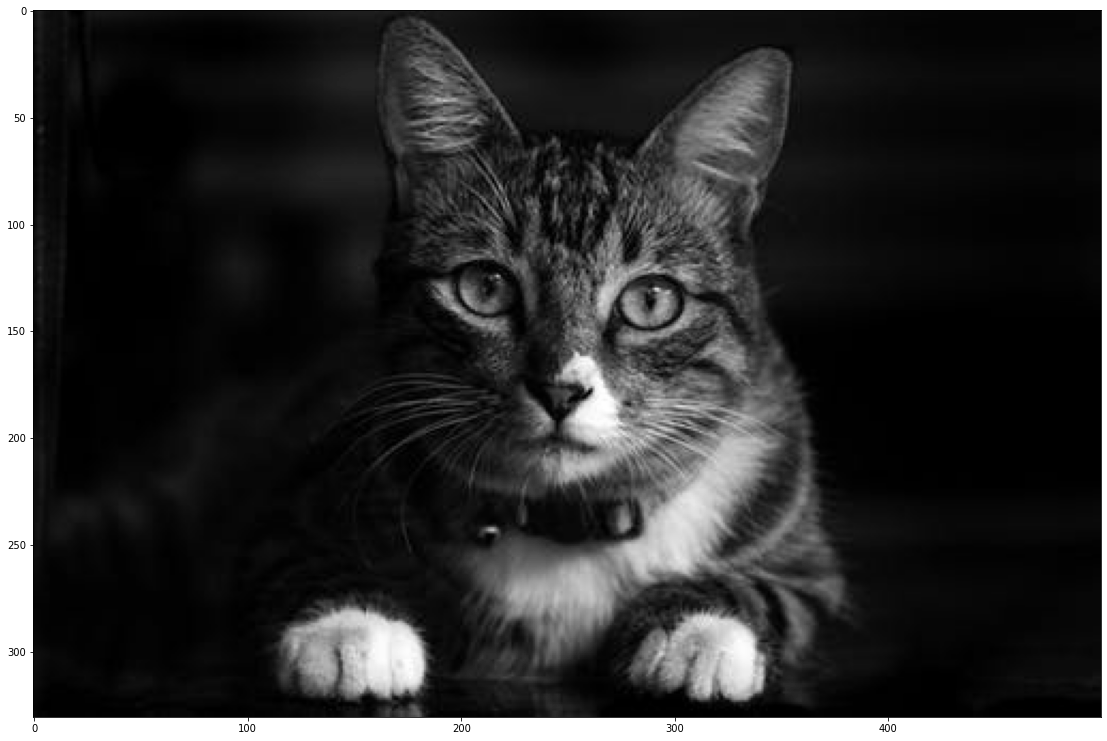

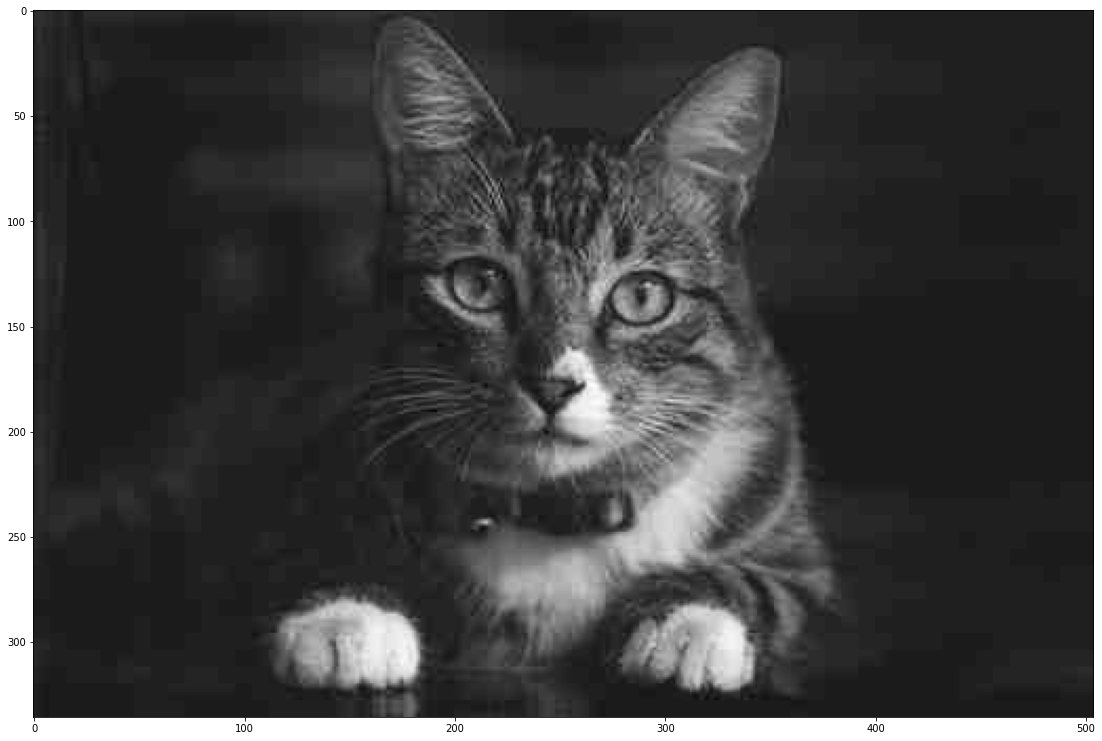

In [68]:
plt.rcParams["figure.figsize"] = [23,13]
plt.imshow(img_arr_gray, cmap='gray')
plt.show()
plt.imshow(dcp_data, cmap='gray')
plt.show()